In [1]:
import numpy as np

rng = np.random.default_rng(0)

eps = 0.4
x = rng.normal(loc=2.0, size=1000000)
noise = rng.normal(scale=np.sqrt(eps * (1 - eps)), size=len(x))
x1 = eps * x + noise
x2 = x - x1

print(np.mean(x1), np.var(x1))
print(np.mean(x2), np.var(x2))

0.8007884526903377 0.39964608136746527
1.2002101179591005 0.6001159038919889


100%|██████████| 1000/1000 [02:17<00:00,  7.29it/s]


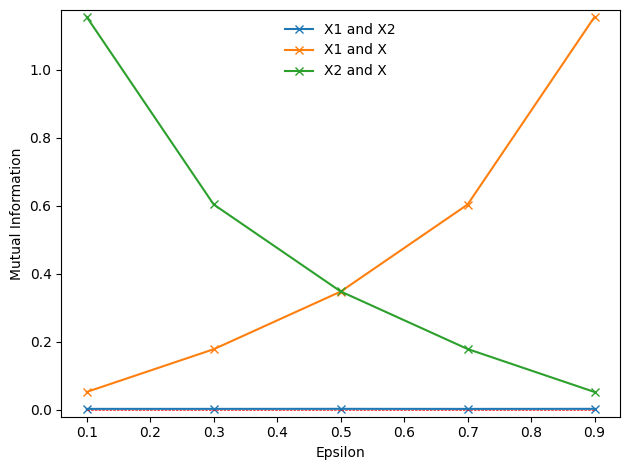

In [62]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

rng = np.random.default_rng(0)

eps_list = [0.1, 0.3, 0.5, 0.7, 0.9]

mi_s1, mi_s2, mi_s = [], [], []
for eps in eps_list:
    mi_list1, mi_list2, mi_list = [], [], []
    for _ in tqdm(range(1000)):
        x = rng.normal(size=10000)
        noise = rng.normal(scale=np.sqrt(eps * (1 - eps)), size=len(x))
        x1 = eps * x + noise
        x2 = x - x1
        mi1 = mutual_info_regression(x1.reshape(-1, 1), x)
        mi2 = mutual_info_regression(x2.reshape(-1, 1), x)
        mi = mutual_info_regression(x2.reshape(-1, 1), x1)
        mi_list1.append(mi1)
        mi_list2.append(mi2)
        mi_list.append(mi)
    mi_s1.append(np.mean(mi_list1))
    mi_s2.append(np.mean(mi_list2))
    mi_s.append(np.mean(mi_list))

plt.plot(eps_list, mi_s, label='X1 and X2', marker="x")
plt.plot(eps_list, mi_s1, label='X1 and X', marker="x")
plt.plot(eps_list, mi_s2, label='X2 and X', marker="x")
plt.ylim(-0.02, np.max(np.concatenate([mi_s, mi_s1, mi_s2])) + 0.02)
plt.ylabel("Mutual Information")
plt.xlabel("Epsilon")
plt.plot(eps_list, np.zeros_like(eps_list), lw=0.5, linestyle='--', color='red')
plt.legend(frameon=False, loc="upper center")
plt.savefig("data_thinning.pdf", bbox_inches='tight', pad_inches=0.0, transparent=True)

plt.show()

100%|██████████| 10000/10000 [08:02<00:00, 20.74it/s]


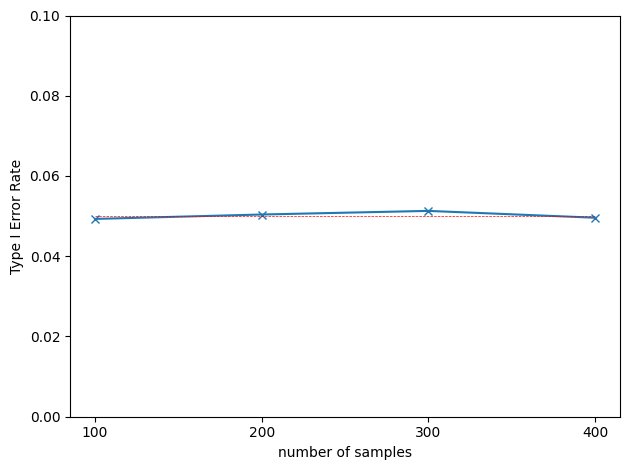

100%|██████████| 10000/10000 [05:01<00:00, 33.16it/s]


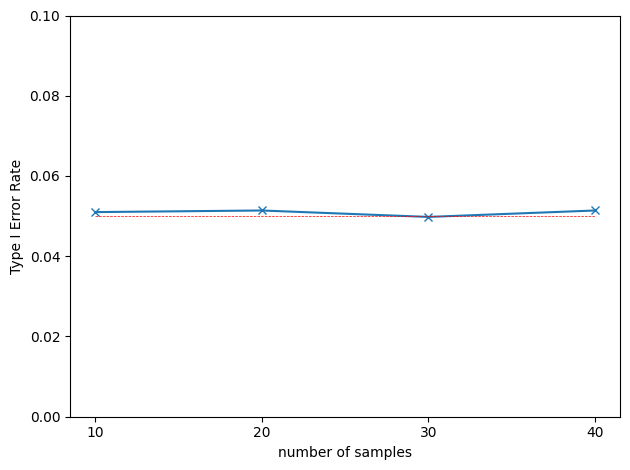

In [110]:
import numpy as np
from scipy.stats import norm
from source.pipelineprocesser import make_pipeline, make_dataset, stepwise_feature_selection

pl = make_pipeline(stepwise_feature_selection(*make_dataset(), parameters=5))
rng = np.random.default_rng(0)
iters = 10000

n_list = [100, 200, 300, 400]
p = 20

fpr_list = []
for n in n_list:
    p_value_list = []
    for _ in tqdm(range(iters)):
        X = rng.normal(size=(n, p))
        y = rng.normal(size=n)

        y1 = 0.5 * y + rng.normal(scale=0.5, size=n)
        y2 = y - y1
        M, _ = pl(X, y1)

        ind = rng.integers(5)
        eta = X[:, M] @ np.linalg.inv(X[:, M].T @ X[:, M])[:, ind]
        stat = eta @ y2 / np.sqrt(0.5 * eta @ eta)
        p_value_list.append(2 * norm.cdf(-np.abs(stat)))
    fpr_list.append(np.mean(np.array(p_value_list) < 0.05))

plt.figure()
plt.plot(n_list, fpr_list, marker="x")
plt.plot(n_list, np.ones_like(n_list) * 0.05, lw=0.5, linestyle='--', color='red')
plt.ylim(0.0, 0.1)
plt.xticks(n_list)
plt.xlabel("number of samples")
plt.ylabel("Type I Error Rate")
plt.savefig("data_thinning_fpr_n.pdf", bbox_inches='tight', pad_inches=0.0, transparent=True)
plt.show()


n = 200
p_list = [10, 20, 30, 40]

fpr_list = []
for p in p_list:
    p_value_list = []
    for _ in tqdm(range(iters)):
        X = rng.normal(size=(n, p))
        y = rng.normal(size=n)

        y1 = 0.5 * y + rng.normal(scale=0.5, size=n)
        y2 = y - y1
        M, _ = pl(X, y1)

        ind = rng.integers(5)
        eta = X[:, M] @ np.linalg.inv(X[:, M].T @ X[:, M])[:, ind]
        stat = eta @ y2 / np.sqrt(0.5 * eta @ eta)
        p_value_list.append(2 * norm.cdf(-np.abs(stat)))
    fpr_list.append(np.mean(np.array(p_value_list) < 0.05))

plt.figure()
plt.plot(p_list, fpr_list, marker="x")
plt.plot(p_list, np.ones_like(p_list) * 0.05, lw=0.5, linestyle='--', color='red')
plt.ylim(0.0, 0.1)
plt.xticks(p_list)
plt.xlabel("number of samples")
plt.ylabel("Type I Error Rate")
plt.savefig("data_thinning_fpr_p.pdf", bbox_inches='tight', pad_inches=0.0, transparent=True)
plt.show()


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

from tqdm import tqdm

import numpy as np
from scipy.stats import norm

import numpy as np
from source.pipelineprocesser import make_pipeline, make_dataset, stepwise_feature_selection

import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

class PararellExperimentBase:
    def __init__(self, signal: float, seed: int, num_results=10000, num_oneset=None):
        self.num_results = num_results
        self.num_worker = 50
        self.signal = signal
        self.rng = np.random.default_rng(seed)
        self.num_oneset = num_oneset
        if self.num_oneset is None:
            self.num_oneset = self.num_results

    def iter_experiment(self, args) -> tuple:
        pass

    def experiment(self, dataset: list) -> list:
        with ProcessPoolExecutor(max_workers=self.num_worker) as executor:
            results = list(
                tqdm(executor.map(self.iter_experiment, dataset), total=len(dataset))
            )
        results = [result for result in results if result is not None]
        return results

    def run_experiment(self):
        results = []
        while len(results) < self.num_results:
            dataset = self.rng.integers(0, 2**32, size=self.num_oneset)
            results += self.experiment(dataset)
        results = results[: self.num_results]
        si, split, thin = zip(*results)
        return np.mean(si), np.mean(split), np.mean(thin)


100%|██████████| 10000/10000 [00:06<00:00, 1598.89it/s]


[0.49813999999999997, 0.8194600000000002, 0.9720200000000001, 0.9986800000000001] [0.38444000000000006, 0.6294, 0.8274600000000002, 0.9472800000000001] [0.39282000000000006, 0.6492600000000001, 0.8495400000000002, 0.9583800000000001]


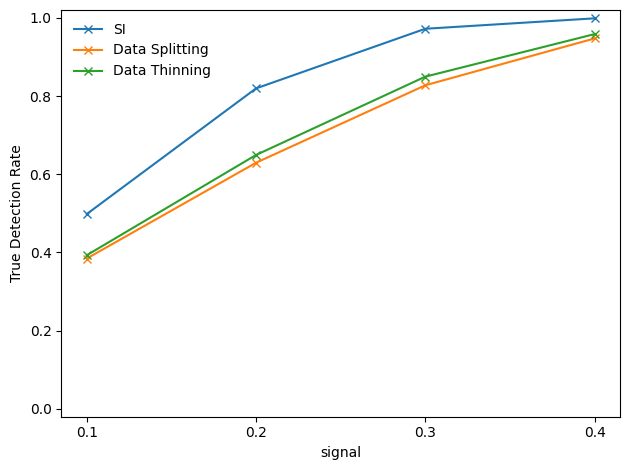

In [4]:
class TrueDetectRateExperiments(PararellExperimentBase):
    def iter_experiment(self, args) -> tuple:
        pl = make_pipeline(stepwise_feature_selection(*make_dataset(), parameters=5))
        n, p = 200, 20
        beta = np.zeros(p)
        beta[:5] = self.signal
        rng = np.random.default_rng(args)

        X = rng.normal(size=(n, p))
        y = X @ beta + rng.normal(size=n)

        M, _ = pl(X, y)
        si = len(np.intersect1d(M, np.arange(5))) / 5.0

        M, _ = pl(X[: n // 2, :], y[: n // 2])
        split = len(np.intersect1d(M, np.arange(5))) / 5.0

        y1 = 0.5 * y + rng.normal(scale=0.5, size=n)
        # y2 = y - y1
        M, _ = pl(X, y1)
        thin = len(np.intersect1d(M, np.arange(5))) / 5.0

        return si, split, thin

signal_list = [0.1, 0.2, 0.3, 0.4]

si_tdr_list, split_tdr_list, thin_tdr_list = [], [], []
for signal in signal_list:
    tdr_experiment = TrueDetectRateExperiments(signal=signal, seed=0)
    si, split, thin = tdr_experiment.run_experiment()
    si_tdr_list.append(si)
    split_tdr_list.append(split)
    thin_tdr_list.append(thin)

print(si_tdr_list, split_tdr_list, thin_tdr_list)

plt.figure()
plt.plot(signal_list, si_tdr_list, label="SI", marker="x")
plt.plot(signal_list, split_tdr_list, label="Data Splitting", marker="x")
plt.plot(signal_list, thin_tdr_list, label="Data Thinning", marker="x")

plt.legend(frameon=False, loc="upper left")
plt.xticks(signal_list)
plt.xlabel("signal")
plt.ylabel("True Detection Rate")
plt.ylim(-0.02, 1.02)
plt.savefig("data_thinning_tdr.pdf", bbox_inches='tight', pad_inches=0.0, transparent=True)
plt.show()


100%|██████████| 10200/10200 [00:29<00:00, 344.21it/s]


[0.2373, 0.5591, 0.883, 0.9918] [0.1919, 0.5214, 0.828, 0.9702] [0.1995, 0.5345, 0.8487, 0.9788]


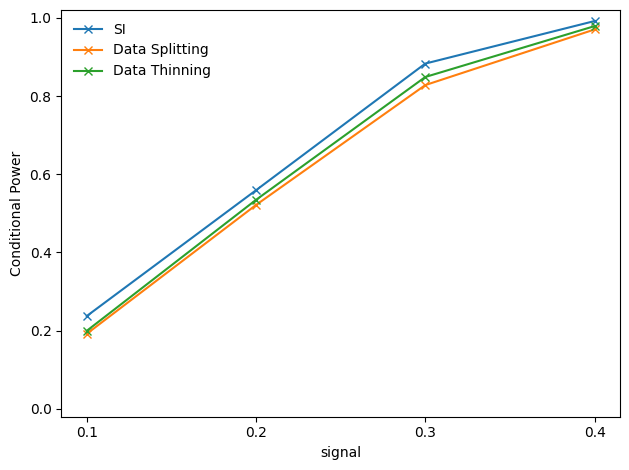

In [2]:
class ConditionalPowerExperiments(PararellExperimentBase):
    def iter_experiment(self, args) -> tuple:
        pl = make_pipeline(stepwise_feature_selection(*make_dataset(), parameters=5))
        n, p = 200, 20
        beta = np.zeros(p)
        beta[:5] = self.signal
        rng = np.random.default_rng(args)

        X = rng.normal(size=(n, p))
        y = X @ beta + rng.normal(size=n)

        M, _ = pl(X[: n // 2, :], y[: n // 2])
        ind = rng.integers(5)
        if M[ind] not in np.arange(5):
            return None
        eta = X[n // 2:, M] @ np.linalg.inv(X[n // 2:, M].T @ X[n // 2:, M])[:, ind]
        stat = eta @ y[n // 2:] / np.sqrt(eta @ eta)
        split = 2 * norm.cdf(-np.abs(stat)) < 0.05

        y1 = 0.5 * y + rng.normal(scale=0.5, size=n)
        y2 = y - y1
        M, _ = pl(X, y1)
        ind = rng.integers(5)
        if M[ind] not in np.arange(5):
            return None
        eta = X[:, M] @ np.linalg.inv(X[:, M].T @ X[:, M])[:, ind]
        stat = eta @ y2 / np.sqrt(0.5 * eta @ eta)
        thin = 2 * norm.cdf(-np.abs(stat)) < 0.05

        M, _ = pl(X, y)
        ind = rng.integers(5)
        if M[ind] not in np.arange(5):
            return None
        _, si_p_value = pl.inference(X, y, 1.0, ind)
        si = si_p_value < 0.05

        return si, split, thin


signal_list = [0.1, 0.2, 0.3, 0.4]

si_cpower_list, split_cpower_list, thin_cpower_list = [], [], []
for signal in signal_list:
    num_oneset = 50000 if signal <= 0.1 else 10200
    cpower_experiment = ConditionalPowerExperiments(signal=signal, seed=0, num_oneset=num_oneset)
    si, split, thin = cpower_experiment.run_experiment()
    si_cpower_list.append(si)
    split_cpower_list.append(split)
    thin_cpower_list.append(thin)

print(si_cpower_list, split_cpower_list, thin_cpower_list)

plt.figure()
plt.plot(signal_list, si_cpower_list, label="SI", marker="x")
plt.plot(signal_list, split_cpower_list, label="Data Splitting", marker="x")
plt.plot(signal_list, thin_cpower_list, label="Data Thinning", marker="x")

plt.legend(frameon=False, loc="upper left")
plt.xticks(signal_list)
plt.xlabel("signal")
plt.ylabel("Conditional Power")
plt.ylim(-0.02, 1.02)
plt.savefig("data_thinning_cpower.pdf", bbox_inches='tight', pad_inches=0.0, transparent=True)
plt.show()


100%|██████████| 10000/10000 [00:32<00:00, 309.41it/s]


[0.0979, 0.4267, 0.8417, 0.9885] [0.0636, 0.3111, 0.6726, 0.9157] [0.0656, 0.3347, 0.7135, 0.935]


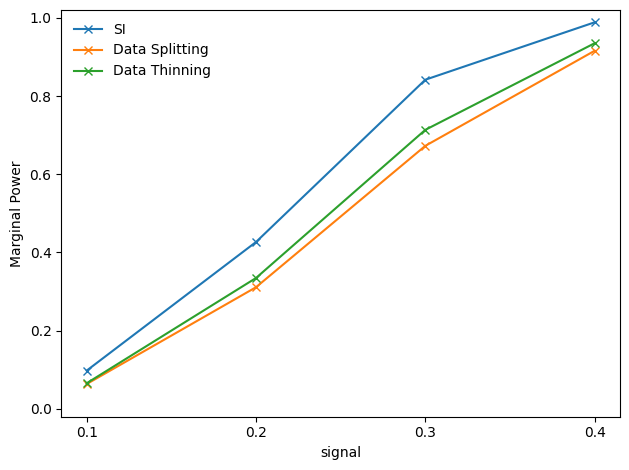

In [5]:
class MarginalPowerExperiments(PararellExperimentBase):
    def iter_experiment(self, args) -> tuple:
        pl = make_pipeline(stepwise_feature_selection(*make_dataset(), parameters=5))
        n, p = 200, 20
        beta = np.zeros(p)
        beta[:5] = self.signal
        rng = np.random.default_rng(args)

        X = rng.normal(size=(n, p))
        y = X @ beta + rng.normal(size=n)

        M, _ = pl(X[: n // 2, :], y[: n // 2])
        ind = rng.integers(5)
        if M[ind] not in np.arange(5):
            split = False
        else:
            eta = X[n // 2:, M] @ np.linalg.inv(X[n // 2:, M].T @ X[n // 2:, M])[:, ind]
            stat = eta @ y[n // 2:] / np.sqrt(eta @ eta)
            split = 2 * norm.cdf(-np.abs(stat)) < 0.05

        y1 = 0.5 * y + rng.normal(scale=0.5, size=n)
        y2 = y - y1
        M, _ = pl(X, y1)
        ind = rng.integers(5)
        if M[ind] not in np.arange(5):
            thin = False
        else:
            eta = X[:, M] @ np.linalg.inv(X[:, M].T @ X[:, M])[:, ind]
            stat = eta @ y2 / np.sqrt(0.5 * eta @ eta)
            thin = 2 * norm.cdf(-np.abs(stat)) < 0.05

        M, _ = pl(X, y)
        ind = rng.integers(5)
        if M[ind] not in np.arange(5):
            si = False
        else:
            _, si_p_value = pl.inference(X, y, 1.0, ind)
            si = si_p_value < 0.05

        return si, split, thin


signal_list = [0.1, 0.2, 0.3, 0.4]

si_mpower_list, split_mpower_list, thin_mpower_list = [], [], []
for signal in signal_list:
    mpower_experiment = MarginalPowerExperiments(signal=signal, seed=0)
    si, split, thin = mpower_experiment.run_experiment()
    si_mpower_list.append(si)
    split_mpower_list.append(split)
    thin_mpower_list.append(thin)

print(si_mpower_list, split_mpower_list, thin_mpower_list)

plt.figure()
plt.plot(signal_list, si_mpower_list, label="SI", marker="x")
plt.plot(signal_list, split_mpower_list, label="Data Splitting", marker="x")
plt.plot(signal_list, thin_mpower_list, label="Data Thinning", marker="x")

plt.legend(frameon=False, loc="upper left")
plt.xticks(signal_list)
plt.xlabel("signal")
plt.ylabel("Marginal Power")
plt.ylim(-0.02, 1.02)
plt.savefig("data_thinning_mpower.pdf", bbox_inches='tight', pad_inches=0.0, transparent=True)
plt.show()


In [ ]:
si_tdr_list, split_tdr_list, thin_tdr_list = np.array(si_tdr_list), np.array(split_tdr_list), np.array(thin_tdr_list)
si_cpower_list, split_cpower_list, thin_cpower_list = np.array(si_cpower_list), np.array(split_cpower_list), np.array(thin_cpower_list)
si_mpower_list, split_mpower_list, thin_mpower_list = np.array(si_mpower_list), np.array(split_mpower_list), np.array(thin_mpower_list)

print(si_tdr_list * si_cpower_list - si_mpower_list)
print(split_tdr_list * split_cpower_list - split_mpower_list)
print(thin_tdr_list * thin_cpower_list - thin_mpower_list)